In [1]:
import os
import numpy as np
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
with zipfile.ZipFile('archive.zip','r') as f:
    f.extractall('archive')

In [3]:
crops = ['jute','maize','rice','sugarcane','wheat']
paths = ['archive/crop_images','archive/kag2','archive/test_crop_image']

In [4]:
img_height = 256 
img_width = 256
batch_size = 32
def load_data(path):
    data = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        batch_size=batch_size, 
        image_size=(img_height,img_width),
        shuffle=True, seed=0
    )
    return data


In [5]:
train = load_data(paths[1])
dev = load_data(paths[0])

Found 804 files belonging to 5 classes.
Found 201 files belonging to 5 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dev = dev.cache().prefetch(buffer_size=AUTOTUNE)


In [7]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [8]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])


In [9]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0

In [10]:
epochs = 10
history = model.fit(
    train,
    validation_data = dev,epochs = epochs
)

Epoch 1/10
26/26 [==============================] - 4s 78ms/step - loss: 1.8529 - accuracy: 0.2557 - val_loss: 1.3546 - val_accuracy: 0.4726
Epoch 2/10
26/26 [==============================] - 1s 47ms/step - loss: 1.3166 - accuracy: 0.4546 - val_loss: 1.1225 - val_accuracy: 0.5920
Epoch 3/10
26/26 [==============================] - 1s 47ms/step - loss: 1.0627 - accuracy: 0.6110 - val_loss: 0.6965 - val_accuracy: 0.8358
Epoch 4/10
26/26 [==============================] - 1s 48ms/step - loss: 0.7644 - accuracy: 0.7248 - val_loss: 0.4139 - val_accuracy: 0.9005
Epoch 5/10
26/26 [==============================] - 1s 47ms/step - loss: 0.3885 - accuracy: 0.8940 - val_loss: 0.2736 - val_accuracy: 0.9204
Epoch 6/10
26/26 [==============================] - 1s 47ms/step - loss: 0.2928 - accuracy: 0.9150 - val_loss: 0.1279 - val_accuracy: 0.9701
Epoch 7/10
26/26 [==============================] - 1s 48ms/step - loss: 0.1257 - accuracy: 0.9733 - val_loss: 0.0466 - val_accuracy: 0.9950
Epoch 8/10
26

In [11]:
acc = history.history['accuracy']
dev_acc = history.history['val_accuracy']
loss = history.history['loss']
dev_loss = history.history['val_loss']
epochs_range = range(epochs)


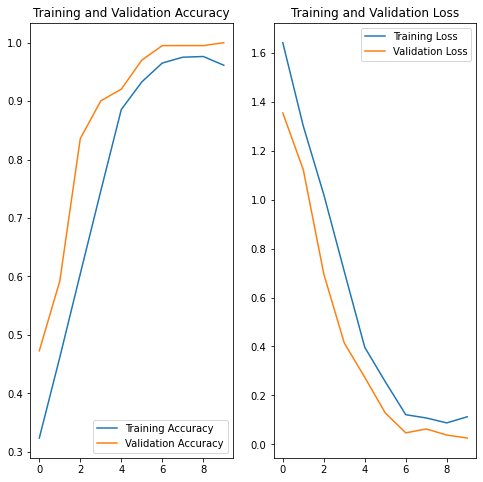

In [12]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, dev_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, dev_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
